In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import seaborn

In [2]:
train_nsl_kdd_dataset_path = "NSL_KDD_Dataset/KDDTrain+.txt"
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

categoricalColumns = col_names[[1,2,3]]
binaryColumns = col_names[[6, 11, 13, 14, 20, 21]]
numericColumns = col_names[list(set(range(41)) - set([1,2,3]) - set([6, 11, 13, 14, 20, 21]))]

train = pd.read_csv(train_nsl_kdd_dataset_path, header=None)
train.drop([42], 1, inplace=True)
train.columns = col_names
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [3]:
train.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [4]:
# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',
   
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

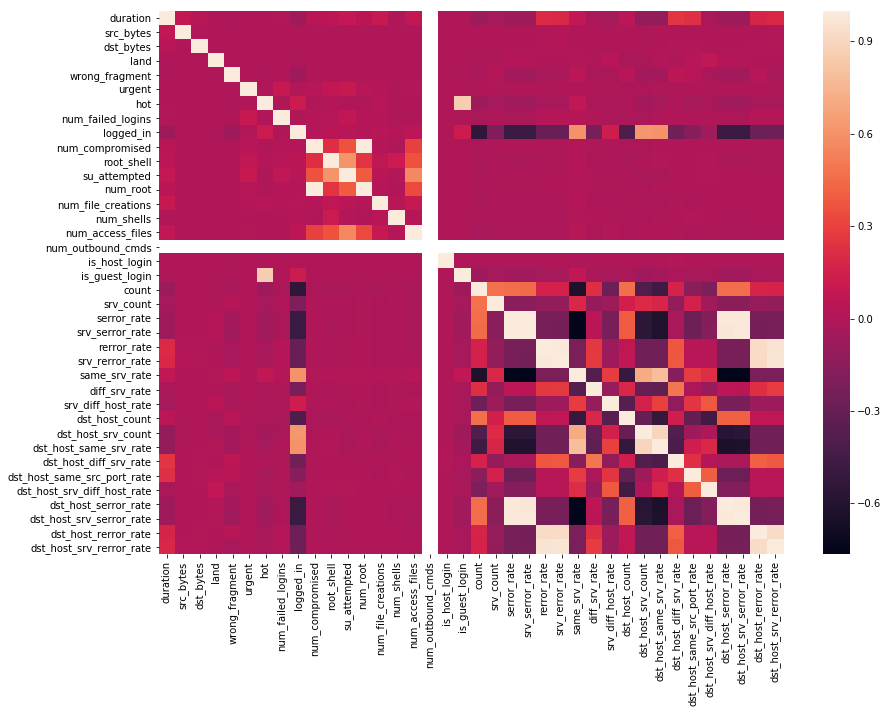

In [28]:
plt.figure(figsize=(14, 10))
seaborn.heatmap(train.corr())



## Things to do
1. One hot encode the vector
2. Read up the papers which have analyzed this dataset and perform the feature engineering performed
3. Train Multiple classifier
4. Setup a spark cluster for this work, even a single node one works

## Data Analysis


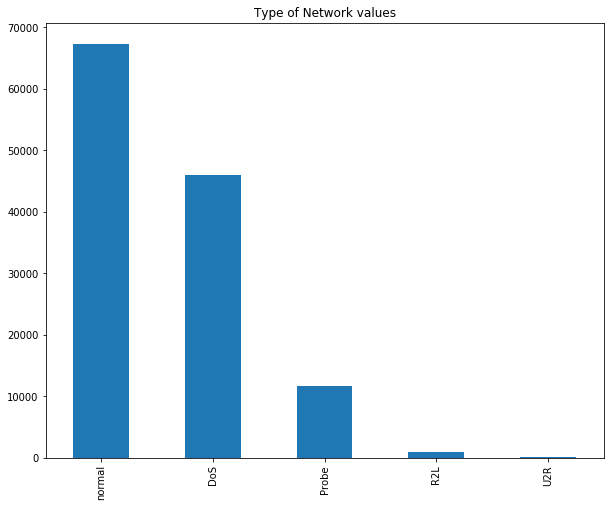

In [15]:
plt.figure(figsize=(10, 8))
train['labels'].map(lambda x: attack_dict[x]).value_counts().plot.bar(title='Type of Network values')

In [97]:
trainDescribe = train[numericColumns].describe()
trainDescribe.T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03
num_root,125973.0,0.302192,2.439962e+01,0.0,0.00,0.00,0.00,7.468000e+03
num_file_creations,125973.0,0.012669,4.839351e-01,0.0,0.00,0.00,0.00,4.300000e+01


Columns of interest:
For each of these columns we should check how much of the data is 0
1. wrong_fragment
2. urgent
3. num_failed_logins
4. num_shells
5. num_access_files
6. num_outbound_cmds
7. rerror_rate
8. srv_rerror_rate
9. srv_diff_host_rate
10. dst_host_serror_rate
11. dst_host_same_src_port_rate
12. dst_host_rerror_rate
13. dst_host_srv_rerror_rate

In [100]:
cols_to_check = ['wrong_fragment', 'urgent', 'num_failed_logins', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                 'rerror_rate', 'srv_rerror_rate', 'srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_same_src_port_rate',
                'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
train[cols_to_check].quantile([0.8, 0.95])

,wrong_fragment,urgent,num_failed_logins,num_shells,num_access_files,num_outbound_cmds,rerror_rate,srv_rerror_rate,srv_diff_host_rate,dst_host_serror_rate,dst_host_same_src_port_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,1.0,0.15,0.0,0.0
0.95,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.00,1.0,1.00,1.0,1.0


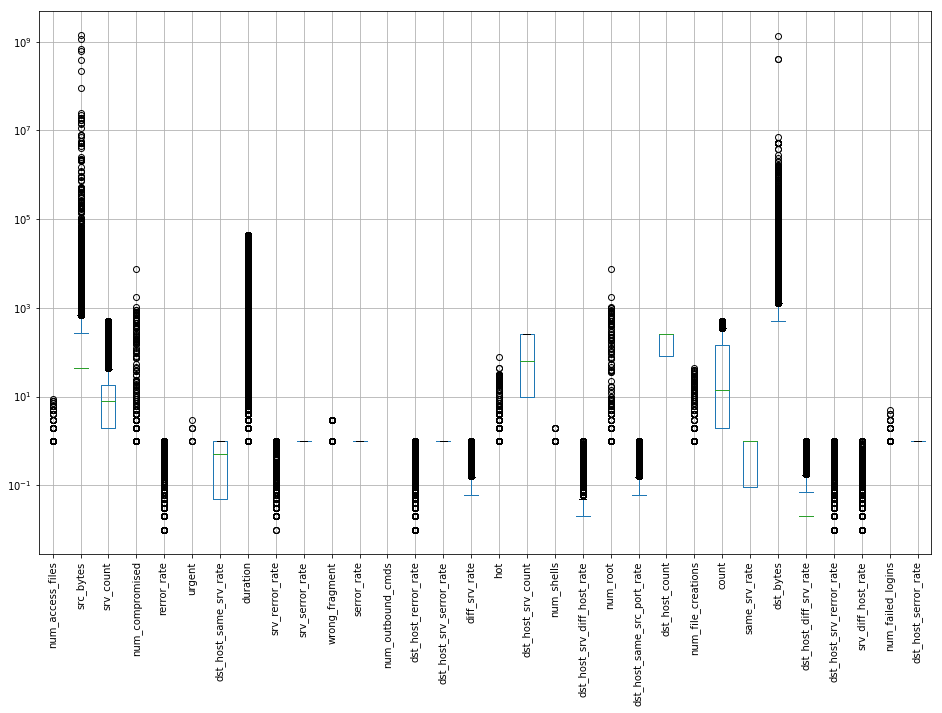

In [15]:
#So there are no negative value so the data looks clean enough to work with
#print trainDescribe.T[(trainDescribe.T['min'] < 0) ]
#colsWith75Zero = trainDescribe.T[(trainDescribe.T['75%'] == 0)].T.columns
#print 'There are', len(colsWith75Zero), 'Columns with 75% of data 0: \n', colsWith75Zero
fig, ax = plt.subplots(figsize=(16, 10))
train.boxplot(list( set(numericColumns)), rot=90, ax=ax)
ax.set_yscale('log')

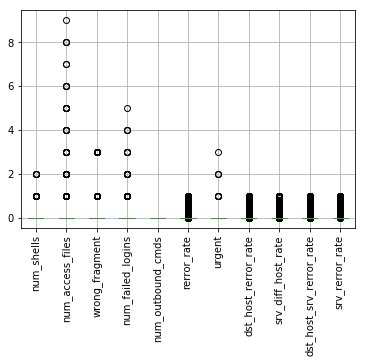

In [85]:
train.boxplot(list(set(colsWith75Zero) - set(['duration', u'num_compromised', 'num_root', 'hot', u'num_file_creations'])), rot=90)

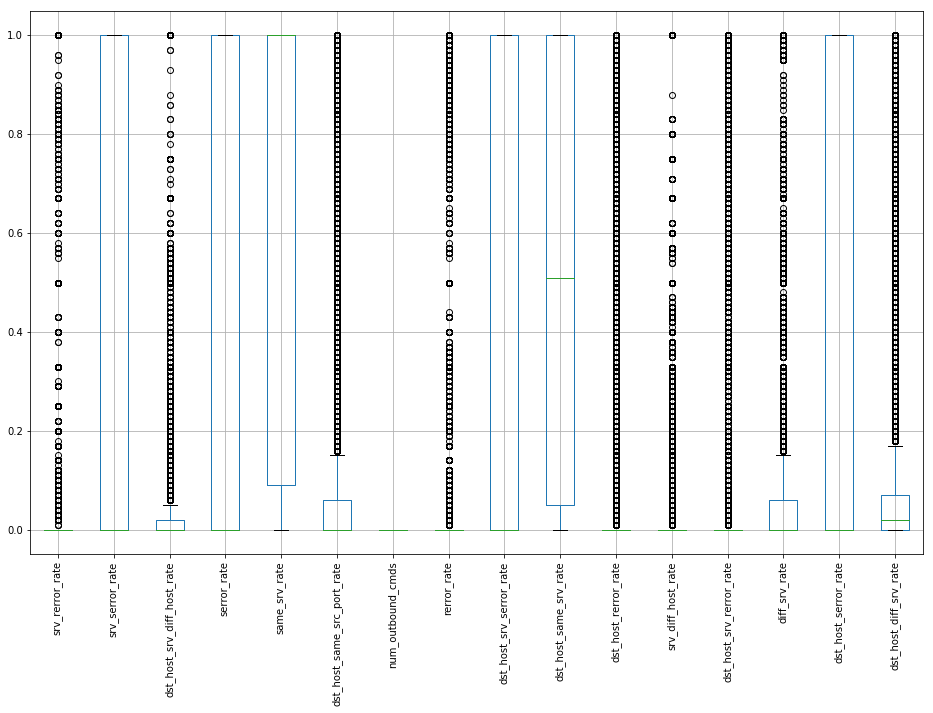

In [86]:
#Most of the things seems to be mostly near zero
plt.figure(figsize=(16, 10))
colsWithMaxLessThan1 = list(set(trainDescribe.columns) -  set(trainDescribe.T[trainDescribe.T['max'] > 1].T.columns))
train.boxplot(colsWithMaxLessThan1, rot=90)

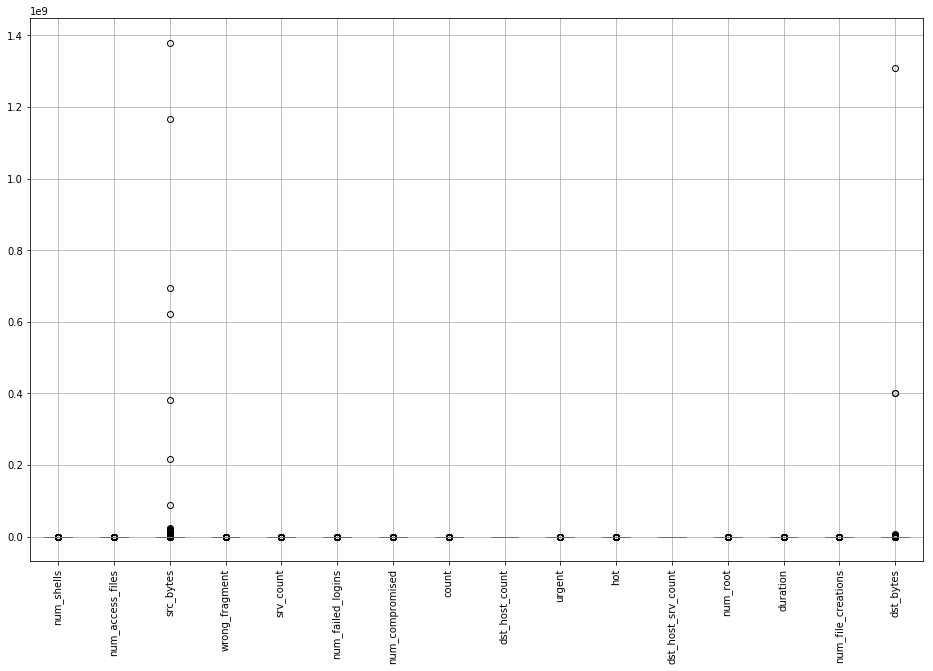

In [88]:
#Plot of columns with max > 1
plt.figure(figsize=(16, 10))
colsWithMaxMoreThan1 = list(set(trainDescribe.T[trainDescribe.T['max'] > 1].T.columns))
train.boxplot(colsWithMaxMoreThan1, rot=90)

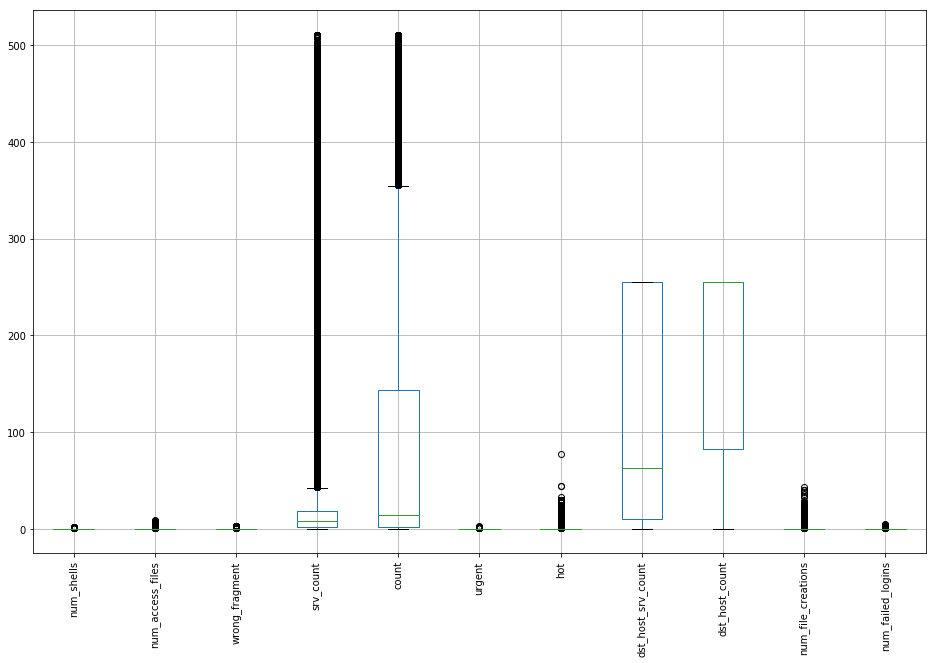

In [91]:
#Plot of columns with max > 1 but with certain features removed to better understand the remaining ones
plt.figure(figsize=(16, 10))
train.boxplot(list(set(trainDescribe.T[trainDescribe.T['max'] > 1].T.columns) - set(['src_bytes', 'dst_bytes','duration', u'num_compromised', 'num_root'])), rot=90)

Given the above plots, the following observations can be made
1. The columns 'duration', 'num_compromised', 'num_root' have 75% of the data zero but they also do have a lot of high value data points as well. A box plot shows that most of the non-zero data lies in the outlier region

2. The feature values range over a huge domain, in such cases normalization should help simpler linear models such as 
Logistic Regression to 

3. For the following 6 features: wrong_fragment, urgent, num_failed_logins, num_shells, num_access_files, num_outbound_cmds 95% of the data is 0. So we can safely remove them from our experimentation

In [73]:
set(colsWithMaxLessThan1).intersection(set(colsWith75Zero))

{'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'is_guest_login',
 'is_host_login',
 'land',
 'num_outbound_cmds',
 'rerror_rate',
 'root_shell',
 'srv_diff_host_rate',
 'srv_rerror_rate'}

In [31]:
#Many of the int/float values seems to be near 0 as for many min, 25%, 50% and 75%
#Looking at the only 3 string labels in the dataset
train['labelsMapped'] = train['labels'].map(lambda x: attack_dict[x])
train.groupby(['protocol_type', 'labelsMapped']).count()['duration'].reset_index().sort_values(by=['protocol_type', 'duration'], ascending=False).rename(columns={'duration': 'count'})

,protocol_type,labelsMapped,count
11,udp,normal,12434
9,udp,Probe,1664
8,udp,DoS,892
10,udp,U2R,3
7,tcp,normal,53600
3,tcp,DoS,42188
4,tcp,Probe,5857
5,tcp,R2L,995
6,tcp,U2R,49
1,icmp,Probe,4135


In [33]:
#It seems all network connections using icmp is mostly an attack
train.groupby(['service', 'labelsMapped']).count()['duration'].reset_index().sort_values(by=['service', 'duration'], ascending=False).rename(columns={'duration': 'count'})

,service,labelsMapped,count
156,whois,DoS,670
157,whois,Probe,23
154,vmnet,DoS,606
155,vmnet,Probe,11
152,uucp_path,DoS,676
153,uucp_path,Probe,13
150,uucp,DoS,769
151,uucp,Probe,11
149,urp_i,normal,599
148,urp_i,Probe,3


In [39]:
#print train.service.unique().shape
#print train.flag
train.shape

(125973, 43)

## Data Modeling
Following are the models tried
1. Random Forest classifier
2. XGBoost Classifier

The experimentation results are based on cross validation. Even any hyperparameter tuning should be based on the cross
validation results

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
enc = LabelEncoder()
#
def encodeCategorical(ser):
    return enc.fit_transform(ser)
service_enc = LabelEncoder()
flag_enc = LabelEncoder()
train['service'] = service_enc.fit_transform(train['service'])
train['flag'] = flag_enc.fit_transform(train['flag'])
train_processed = pd.get_dummies(train, columns=['protocol_type'])
train_processed.head()

,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,protocol_type_icmp,protocol_type_tcp,protocol_type_udp
0,0,20,9,491,0,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,normal,0,1,0
1,0,44,9,146,0,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,normal,0,0,1
2,0,49,5,0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,0,1,0
3,0,24,9,232,8153,0,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,normal,0,1,0
4,0,24,9,199,420,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,normal,0,1,0


In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
train_processed['labelsMapped'] = train_processed['labels'].map(lambda x: attack_dict[x])

In [7]:
# Random Forest Classifier
mdl = RandomForestClassifier(n_estimators = 100, max_depth = 15, class_weight="balanced")
X = train_processed.drop(['labelsMapped', 'labels'], 1).reset_index(drop=True)
y = train_processed['labelsMapped'].reset_index(drop=True)
cv = 5
skf = StratifiedKFold(n_splits=cv, random_state = 42)
RandomForestAccuracy = []
fold = 1
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mdl.fit(X_train, y_train)
    pred = mdl.predict(X_test)
    foldAccuracy = accuracy_score(y_test, pred)
    print 'Model Accuracy for fold', fold, 'is', foldAccuracy
    RandomForestAccuracy.append(foldAccuracy)
    fold += 1
print 'The Average accuracy across', cv, 'is', np.array(RandomForestAccuracy).mean()

Model Accuracy for fold 1 is 0.998372822161
Model Accuracy for fold 2 is 0.998650579457
Model Accuracy for fold 3 is 0.998372628404
Model Accuracy for fold 4 is 0.998571031636
Model Accuracy for fold 5 is 0.998412257373
The Average accuracy across 5 is 0.998475863806


In [63]:
skf = StratifiedKFold(n_splits=cv, random_state = 42)
XGBoostAccuracy = []
fold = 1
# setup parameters for xgboost
param = {'objective': 'multi:softmax',
         'eta': 0.001,
         'max_depth': 15,
         'num_class': 5,
         'n_estimators': 100
        }
# scale weight of positive examples

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = encodeCategorical(y[train_index]), encodeCategorical(y[test_index])

    #classWeights = float(np.bincount(y_train).sum()) / (5 * np.bincount(y_train))
    #weights = map(lambda x_: classWeights[x_], y_train)
    
    #dtrain = xgb.DMatrix(X_train, label = y_train, weight = weights)
    #dtest = xgb.DMatrix(X_test, label = y_test)
    #watchlist = [(dtest, 'train'), (dtest, 'test')]
    #num_round = 10
    #bst = xgb.train(param, dtrain, num_round, watchlist)
    mdl_xgb = XGBClassifier(n_estimators = 100, max_depth = 15, learning_rate = 0.01)
    mdl_xgb.fit(X_train, y_train)
    # get prediction
    pred = mdl_xgb.predict(X_test)
    #error_rate = np.sum(pred != y_test) / y_test.shape[0]
    foldAccuracy = accuracy_score(y_test, pred)
    #print('Test error using softmax = {}'.format(error_rate))
    print('Model Accuracy for fold', fold, 'is', foldAccuracy)
    XGBoostAccuracy.append(foldAccuracy)
    fold += 1
print 'The Average accuracy across', cv, 'is', np.array(XGBoostAccuracy).mean()

('Model Accuracy for fold', 1, 'is', 0.9979362622534429)
('Model Accuracy for fold', 2, 'is', 0.99821400222257506)
('Model Accuracy for fold', 3, 'is', 0.99801540049218063)
('Model Accuracy for fold', 4, 'is', 0.99825348311038775)
('Model Accuracy for fold', 5, 'is', 0.99821378954471485)
The Average accuracy across 5 is 0.998126587525


In [39]:
import numpy as np
enc_y = encodeCategorical(y)
#5 * np.bincount(enc_y)
classWeights = float(np.bincount(enc_y).sum()) / (5 * np.bincount(enc_y))


[0.37412351692083812,
 0.37412351692083812,
 0.54857926709778559,
 0.37412351692083812,
 0.37412351692083812,
 0.54857926709778559,
 0.54857926709778559,
 0.54857926709778559,
 0.54857926709778559,
 0.54857926709778559,
 0.54857926709778559,
 0.54857926709778559,
 0.37412351692083812,
 25.321206030150755,
 0.54857926709778559,
 0.54857926709778559,
 0.37412351692083812,
 2.1615133836650653,
 0.37412351692083812,
 0.37412351692083812,
 0.54857926709778559,
 0.54857926709778559,
 0.37412351692083812,
 0.37412351692083812,
 0.54857926709778559,
 0.37412351692083812,
 0.54857926709778559,
 0.37412351692083812,
 0.37412351692083812,
 0.37412351692083812,
 2.1615133836650653,
 0.54857926709778559,
 0.37412351692083812,
 2.1615133836650653,
 0.37412351692083812,
 0.37412351692083812,
 0.37412351692083812,
 0.54857926709778559,
 0.37412351692083812,
 0.54857926709778559,
 0.54857926709778559,
 0.54857926709778559,
 0.37412351692083812,
 0.37412351692083812,
 0.37412351692083812,
 0.54857926709

In [49]:
from sklearn.externals import joblib
mdl.feature_cols = X.columns
joblib.dump(mdl, 'ml_api/RandomForest.pkl')

['ml_api/RandomForest.pkl']

In [64]:
joblib.dump(mdl_xgb, 'ml_api/XGBoost.pkl')

['ml_api/XGBoost.pkl']

## Logistic Regression

### Data Selection for modelling 
1. The following features will be removed - wrong_fragment, urgent, num_failed_logins, num_shells, num_access_files, num_outbound_cmds
2. Normalize the feature set so that the weights don't affect calculations much

In [17]:
import sys
from collections import OrderedDict
e = sys.float_info.epsilon
def calAttributeRatio(df, numericColumns,binaryColumns):
    denom = {}
    ar = {}
    for col in numericColumns:
        denom[col] = df[col].mean();

    for col in numericColumns:
        ar[col] = df.fillna(value=0.0).groupby('labelsMapped')[[col]].mean().max().values[0]/(denom[col])

    def test_sum(series):
        return (series.sum()/(len(series)-series.sum()+e))
    for col in binaryColumns:
        groups = df.groupby('labelsMapped')[[col]]
        ar[col] = groups.aggregate([test_sum]).max().values[0]
    return ar

ar_op = calAttributeRatio(train_processed,numericColumns,binaryColumns)
print(OrderedDict(sorted(ar_op.items(), key=lambda v: -v[1])))
def selectTopFeaturesByAR(ar_op, min_ar):
    return [c for c in ar_op.keys() if ar_op[c]>=min_ar]

/Users/shashankbhushan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


OrderedDict([('num_shells', 326.11353550295854), ('urgent', 173.03983516483518), ('num_file_creations', 62.233624927703879), ('num_failed_logins', 46.038556418455919), ('hot', 40.774516817095183), ('logged_in', 10.569767441860465), ('dst_bytes', 9.1548543553434012), ('src_bytes', 8.4640642049489454), ('duration', 7.2258291572125568), ('dst_host_srv_diff_host_rate', 5.7568806827546997), ('dst_host_diff_srv_rate', 4.8373418489732671), ('num_access_files', 4.6948792486583191), ('dst_host_same_src_port_rate', 4.3930803788834885), ('num_compromised', 4.3385392749839271), ('diff_srv_rate', 4.0690854850685172), ('dst_host_srv_rerror_rate', 3.667920527965804), ('srv_rerror_rate', 3.6677418023254122), ('rerror_rate', 3.6455860878284372), ('dst_host_rerror_rate', 3.2795669242442695), ('srv_diff_host_rate', 3.0815657101101674), ('wrong_fragment', 2.7428963354889282), ('dst_host_srv_serror_rate', 2.6731595957142456), ('srv_serror_rate', 2.6432463184901405), ('serror_rate', 2.6310546426370025), ('d

from sklearn import manifold
features = selectTopFeaturesByAR(ar_op,1.00)

n_components = 2

tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(train_processed[features])
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler
Cols_to_drop = ['wrong_fragment', 'urgent', 'num_failed_logins', 'num_shells', 'num_access_files', 'num_outbound_cmds']
train_logistic = train_processed.drop(Cols_to_drop, 1)
scaler = MinMaxScaler()
train_logistic.columns

Index([u'duration', u'service', u'flag', u'src_bytes', u'dst_bytes', u'land',
       u'hot', u'logged_in', u'num_compromised', u'root_shell',
       u'su_attempted', u'num_root', u'num_file_creations', u'is_host_login',
       u'is_guest_login', u'count', u'srv_count', u'serror_rate',
       u'srv_serror_rate', u'rerror_rate', u'srv_rerror_rate',
       u'same_srv_rate', u'diff_srv_rate', u'srv_diff_host_rate',
       u'dst_host_count', u'dst_host_srv_count', u'dst_host_same_srv_rate',
       u'dst_host_diff_srv_rate', u'dst_host_same_src_port_rate',
       u'dst_host_srv_diff_host_rate', u'dst_host_serror_rate',
       u'dst_host_srv_serror_rate', u'dst_host_rerror_rate',
       u'dst_host_srv_rerror_rate', u'labels', u'protocol_type_icmp',
       u'protocol_type_tcp', u'protocol_type_udp', u'labelsMapped'],
      dtype='object')

In [14]:
col_to_not_scale = [u'service', u'flag', u'protocol_type_tcp', u'protocol_type_udp', u'labelsMapped', ]
set(train_logistic.columns) - set(numericColumns)

{'flag',
 'is_guest_login',
 'is_host_login',
 'labels',
 'labelsMapped',
 'land',
 'logged_in',
 'protocol_type_icmp',
 'protocol_type_tcp',
 'protocol_type_udp',
 'root_shell',
 'service',
 'su_attempted'}

## Setting evaluation

In [23]:
testData = pd.read_csv("NSL_KDD_Dataset/KDDTest+.txt", header=None)

categoricalColumns = col_names[[1,2,3]]
binaryColumns = col_names[[6, 11, 13, 14, 20, 21]]
numericColumns = col_names[list(set(range(41)) - set([1,2,3]) - set([6, 11, 13, 14, 20, 21]))]


testData.drop([42], 1, inplace=True)
testData.columns = col_names
testData.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


In [34]:
testData['service'] = service_enc.transform(testData['service'])
testData['flag'] = flag_enc.transform(testData['flag'])
testData_processed = pd.get_dummies(testData, columns=['protocol_type'])
train_processed.columns

ValueError: y contains new labels: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 26 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51 52 53 54
 55 56 57 58 59 60 61 62 63 65 66 67 68 69]